In [ ]:
# https://qdrant.tech/documentation/examples/graphrag-qdrant-neo4j/

# https://neo4j.com/blog/developer/neo4j-graphrag-workflow-langchain-langgraph/

# Extracting neighbour nodes
# https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/enhancing_rag_with_graph.ipynb#scrollTo=dY8huoM8tHNX

In [1]:
import os

from dotenv import load_dotenv

In [2]:
## Loading Environment Variables
load_dotenv()

NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_DB = os.getenv("NEO4J_DB")

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

NEO4J_AUTH = (NEO4J_USERNAME, NEO4J_PASSWORD)
INDEX_NAME = "vector_index"

https://neo4j.com/docs/neo4j-graphrag-python/current/user_guide_kg_builder.html

## Let's Create the Knowledge Graph from Raw Text

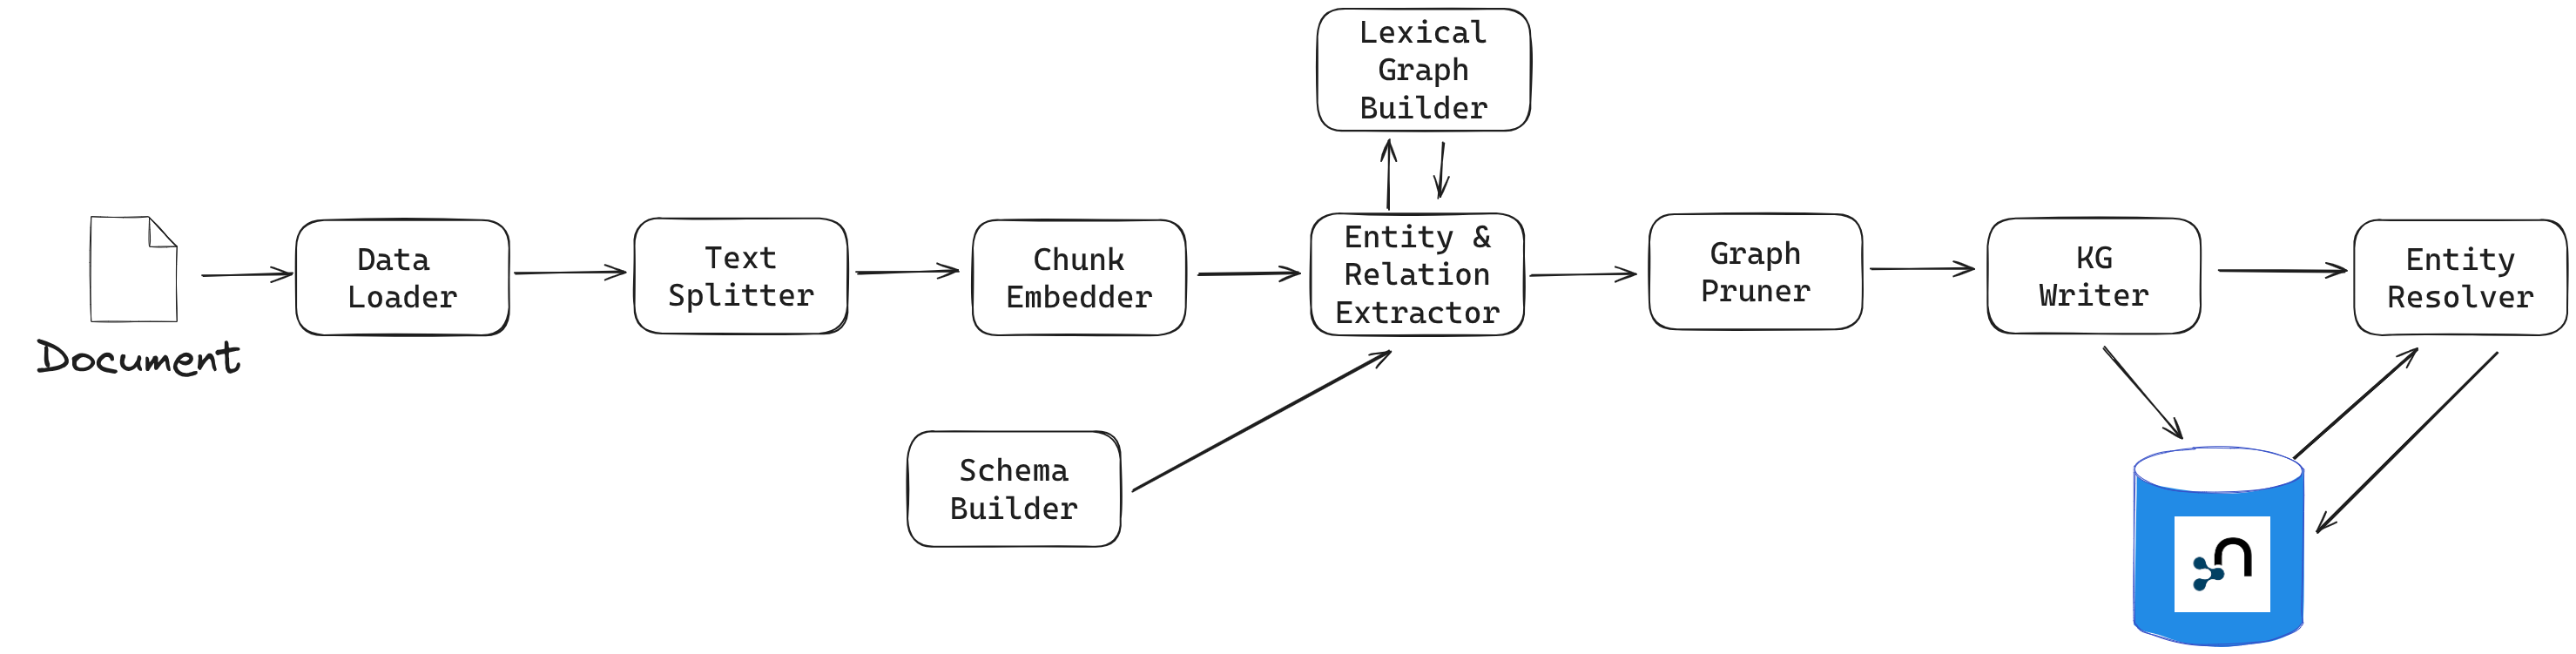

### Load the text data

In [3]:
import wikipedia

In [4]:
# Save the data

harry_potter = wikipedia.page(title="Harry Potter - Wikipedia")
with open("harry potter.txt", "w", encoding="utf-8") as f:
    f.write(harry_potter.content)

In [5]:
url = harry_potter.url
url

'https://en.wikipedia.org/wiki/Harry_Potter_(film_series)'

In [3]:
# load the data
with open("harry potter.txt", encoding="utf-8") as f:
    harry_potter = f.read()

### Create chunks of the data

In [4]:
from llama_index.core.node_parser import SentenceSplitter

In [5]:
text_parser = SentenceSplitter(chunk_size=1024)
text_chunks = text_parser.split_text(harry_potter)

In [6]:
len(text_chunks)

13

### Create Embeddings of Each Chunk

In [10]:
from llama_index.embeddings.google_genai import GoogleGenAIEmbedding
from google.genai.types import EmbedContentConfig

EMBEDDING_SIZE = 768

embedding_config = EmbedContentConfig(output_dimensionality=EMBEDDING_SIZE)
embed_model = GoogleGenAIEmbedding(
    model_name="models/gemini-embedding-001",
    embed_batch_size=100,
    embedding_config=embedding_config,
    api_key=GEMINI_API_KEY
)

In [11]:
chunk_data = []
for chunk_text in text_chunks:
    text_embedding = embed_model.get_text_embedding(chunk_text)
    chunk_data.append((chunk_text, text_embedding))

## Now, Let's build the Knowledge Graph

In [7]:
from neo4j import GraphDatabase

In [8]:
## Connecting to Neo4J instance
driver = GraphDatabase.driver(NEO4J_URI, auth=NEO4J_AUTH)

In [9]:
doc_name = "Harry Potter"
doc_url = "https://en.wikipedia.org/wiki/Harry_Potter_(film_series)"

In [15]:
# Let's Create the Document Node
summary = driver.execute_query(
    """CREATE (a:Document {name: $doc_name, url: $doc_url})""",
    doc_name=doc_name, doc_url=doc_url, database_=NEO4J_DB,
).summary

print("Created {nodes_created} nodes in {time} ms.".format(
    nodes_created=summary.counters.nodes_created,
    time=summary.result_available_after
))

Created 1 nodes in 14 ms.


In [16]:
for chunk_idx, chunk in enumerate(chunk_data, start=1):
    chunk_id = f"{doc_name}_{chunk_idx}"
    chunk_text, chunk_embedding = chunk
    
    summary = driver.execute_query("""
        MATCH (a: Document {name: $doc_name})
        CREATE (b:Chunk {chunk_id: $chunk_id, embedding: $chunk_embedding, text: $chunk_text})
        CREATE (b)-[:PART_OF]->(a)
        """,
        doc_name=doc_name, chunk_id=chunk_id, chunk_embedding=chunk_embedding, chunk_text=chunk_text,
        database_=NEO4J_DB,
    ).summary
    
    print("Created {nodes_created} nodes in {time} ms.".format(
        nodes_created=summary.counters.nodes_created,
        time=summary.result_available_after
    ))

Created 1 nodes in 21 ms.
Created 1 nodes in 2 ms.
Created 1 nodes in 1 ms.
Created 1 nodes in 2 ms.
Created 1 nodes in 1 ms.
Created 1 nodes in 1 ms.
Created 1 nodes in 2 ms.
Created 1 nodes in 1 ms.
Created 1 nodes in 1 ms.
Created 1 nodes in 1 ms.
Created 1 nodes in 9 ms.
Created 1 nodes in 1 ms.
Created 1 nodes in 1 ms.


### Next we define the vector Index

In [17]:
# https://neo4j.com/docs/cypher-manual/current/indexes/semantic-indexes/vector-indexes/#create-vector-index
# Create Vector Index, for chunked nodes

driver.execute_query(
    """
    CREATE VECTOR INDEX $vector_index IF NOT EXISTS
    FOR (c:Chunk)
    ON c.embedding
    OPTIONS { indexConfig: {
        `vector.dimensions`: $embedding_size,
        `vector.similarity_function`: 'cosine'
        }
    }
    """,
    vector_index=INDEX_NAME, embedding_size=EMBEDDING_SIZE,
    database_=NEO4J_DB,
)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x0000024AAF5E3830>, keys=[])

## Now, let's build Entity and Relationship for each chunk

In [10]:
# https://neo4j.com/developer/genai-ecosystem/graphrag-python/
import json

from llama_index.llms.google_genai import GoogleGenAI

import templates

import nest_asyncio
nest_asyncio.apply()

In [11]:
def entity_extraction_chain(text: str):
    llm = GoogleGenAI(model = "gemini-2.5-flash-lite", api_key=GEMINI_API_KEY, temperature=0)
    
    entity_relationship_extraction_prompt = templates.entity_relationship_extraction_template.format(text=text)
    
    response = llm.complete(entity_relationship_extraction_prompt)
    
    response = response.text
    response = response.removeprefix("```json")
    response = response.removesuffix("```")
    
    json_response = json.loads(response)
    
    return json_response
	

In [20]:
chunk_kg = entity_extraction_chain(text_chunks[0])
chunk_kg

{'nodes': [{'id': '0',
   'label': 'BOOK_SERIES',
   'properties': {'name': 'Harry Potter'}},
  {'id': '1', 'label': 'AUTHOR', 'properties': {'name': 'J. K. Rowling'}},
  {'id': '2',
   'label': 'FILM_SERIES',
   'properties': {'name': 'Harry Potter film series',
    'number_of_films': 8,
    'production_start_year': 2001,
    'production_end_year': 2011,
    'total_worldwide_receipts': '$7.7 billion'}},
  {'id': '3',
   'label': 'PRODUCTION_COMPANY',
   'properties': {'name': 'Warner Bros. Pictures'}},
  {'id': '4',
   'label': 'FILM',
   'properties': {'name': "Harry Potter and the Philosopher's Stone",
    'release_year': 2001}},
  {'id': '5',
   'label': 'FILM',
   'properties': {'name': 'Harry Potter and the Deathly Hallows – Part 2',
    'release_year': 2011,
    'worldwide_gross': '$1.3 billion',
    'ranking_all_time_grossing': 20}},
  {'id': '6',
   'label': 'FILM_SERIES',
   'properties': {'name': 'Fantastic Beasts', 'start_year': 2016}},
  {'id': '7',
   'label': 'MEDIA_FRAN

In [12]:
def add_node(node, chunk_id):
    node_property = {"node_id": node["id"]} | node["properties"]
    node_property_str = ', '.join(f'{key}: ${key}' for key in node_property)
    
    result = driver.execute_query(f"""
        MATCH (a:Chunk {{chunk_id: $chunk_id}})
        CREATE (b:{node["label"]} {{ {node_property_str} }} )
        CREATE (a)-[:CONTAINS]->(b)
        """,
        chunk_id=chunk_id, **node_property,
        database_=NEO4J_DB,
    ).summary

In [13]:
def add_relationship(relationship):
    node_label_a = relationship["start_node_label"]
    node_label_b = relationship["end_node_label"]
    rel_type=relationship["type"]
    
    if relationship["properties"] == {}:
        result = driver.execute_query(f"""
            MATCH (a:{node_label_a} {{node_id: $node_id_a}})
            MATCH (b:{node_label_b} {{node_id: $node_id_b}})
            CREATE (a)-[:{rel_type}]->(b)
            """,
            node_id_a=relationship["start_node_id"], node_id_b=relationship["end_node_id"],
            database_=NEO4J_DB,
        ).summary
    else:
        relationship_prop = relationship["properties"]
        relationship_prop_str = ', '.join(f'{key}: ${key}' for key in relationship["properties"])
        result = driver.execute_query(f"""
            MATCH (a:{node_label_a} {{node_id: $node_id_a}})
            MATCH (b:{node_label_b} {{node_id: $node_id_b}})
            CREATE (a)-[:{rel_type} {{ {relationship_prop_str} }}]->(b)
            """,
            node_id_a=relationship["start_node_id"], node_id_b=relationship["end_node_id"],
            **relationship_prop,
            database_=NEO4J_DB,
        ).summary

In [14]:
def add_knowledge_graph(knowledge_graph: dict, chunk_id):
    nodes = knowledge_graph["nodes"]
    relationships = knowledge_graph["relationships"]
    
    for node in nodes:
        add_node(node, chunk_id=chunk_id)
    print(f"All Nodes added for chunk id: {chunk_id}.")
    
    for relationship in relationships:
        add_relationship(relationship)
    print(f"All relationships created for chunk id: {chunk_id}")
    

In [15]:
def validate_chunk_kg(chunk_kg):
    for idx,node in enumerate(chunk_kg["nodes"]):
        if "id" not in node:
            return f"node id is not found at idx: {idx}"
        
        if "label" not in node:
            return f"node label is not found at idx: {idx}"
        
        if "properties" not in node:
            return f"node properties is not found at idx: {idx}"
    
    for idx, relationship in enumerate(chunk_kg["relationships"]):
        if "type" not in relationship:
            return f"relationship type is not found at idx: {idx}"
        if "start_node_id" not in relationship:
            return f"relationship start_node_id is not found at idx: {idx}"
        if "start_node_label" not in relationship:
            return f"relationship start_node_label is not found at idx: {idx}"
        if "end_node_id" not in relationship:
            return f"relationship end_node_id is not found at idx: {idx}"
        if "end_node_label" not in relationship:
            return f"relationship end_node_label is not found at idx: {idx}"
        if "properties" not in relationship:
            return f"relationship properties is not found at idx: {idx}"
    
    return "success"

In [ ]:
for chunk_idx, chunk in enumerate(text_chunks):
    chunk_id = f"{doc_name}_{chunk_idx}"
    chunk_kg = entity_extraction_chain(chunk)
    response = validate_chunk_kg(chunk_kg)
    
    if response =="success":
        add_knowledge_graph(knowledge_graph=chunk_kg, chunk_id=chunk_id)
    else:
        print(response)
        break

In [52]:
query = """
MATCH (c:Chunk {chunk_id: 'Harry Potter_3'})-[:CONTAINS]->(child)
RETURN elementId(child)
"""

result = driver.execute_query(query)

In [53]:
result

EagerResult(records=[<Record elementId(child)='4:8b9b9843-6947-454f-8dad-2af1a780bfdc:71'>, <Record elementId(child)='4:8b9b9843-6947-454f-8dad-2af1a780bfdc:72'>, <Record elementId(child)='4:8b9b9843-6947-454f-8dad-2af1a780bfdc:73'>, <Record elementId(child)='4:8b9b9843-6947-454f-8dad-2af1a780bfdc:74'>, <Record elementId(child)='4:8b9b9843-6947-454f-8dad-2af1a780bfdc:75'>, <Record elementId(child)='4:8b9b9843-6947-454f-8dad-2af1a780bfdc:76'>, <Record elementId(child)='4:8b9b9843-6947-454f-8dad-2af1a780bfdc:77'>, <Record elementId(child)='4:8b9b9843-6947-454f-8dad-2af1a780bfdc:78'>, <Record elementId(child)='4:8b9b9843-6947-454f-8dad-2af1a780bfdc:79'>, <Record elementId(child)='4:8b9b9843-6947-454f-8dad-2af1a780bfdc:80'>, <Record elementId(child)='4:8b9b9843-6947-454f-8dad-2af1a780bfdc:81'>, <Record elementId(child)='4:8b9b9843-6947-454f-8dad-2af1a780bfdc:82'>, <Record elementId(child)='4:8b9b9843-6947-454f-8dad-2af1a780bfdc:83'>, <Record elementId(child)='4:8b9b9843-6947-454f-8dad-2af1

In [54]:
node_ids = [item[0] for item in result[0]]

node_ids[:5]

['4:8b9b9843-6947-454f-8dad-2af1a780bfdc:71',
 '4:8b9b9843-6947-454f-8dad-2af1a780bfdc:72',
 '4:8b9b9843-6947-454f-8dad-2af1a780bfdc:73',
 '4:8b9b9843-6947-454f-8dad-2af1a780bfdc:74',
 '4:8b9b9843-6947-454f-8dad-2af1a780bfdc:75']

In [ ]:
query = """
MATCH (p)-[r]-()
WHERE elementID(p)=$node_id
DELETE r;
"""

for node_id in node_ids[1:2]:
    result = driver.execute_query(query, node_id="4:8b9b9843-6947-454f-8dad-2af1a780bfdc:71")

In [57]:
result

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x0000019CA0EDE210>, keys=[])

In [ ]:
# For each chunk node, we will create nodes and relationships from each chunk
# all nodes from a chunk, will be connected to that chunk.

# Vector Search will narrow down to chunk
# Then use cypher chain to create cypher command from the user query.
# apply the cypher query narrowed down to the selected chunk nodes.

In [ ]:
# Automatic Schema Extraction
# Instead of manually defining the schema, you can use the SchemaFromTextExtractor component to automatically extract a schema from your text using an LLM:

from neo4j_graphrag.experimental.components.schema import SchemaFromTextExtractor
from neo4j_graphrag.llm import OpenAILLM

# Instantiate the automatic schema extractor component
schema_extractor = SchemaFromTextExtractor(
    llm=OpenAILLM(
        model_name="gpt-4o",
        model_params={
            "max_tokens": 2000,
            "response_format": {"type": "json_object"},
        },
    )
)

# Extract the schema from the text
extracted_schema = await schema_extractor.run(text="Some text")

In [ ]:
# Entity and Relation Extractor¶
# This component is responsible for extracting the relevant entities and relationships from each text chunk, using the schema as guideline.

# This package contains an LLM-based entity and relationships extractor: LLMEntityRelationExtractor. It can be used in this way:

from neo4j_graphrag.experimental.components.entity_relation_extractor import (
    LLMEntityRelationExtractor,
)
from neo4j_graphrag.experimental.components.types import (
    TextChunks,
    TextChunk
)
from neo4j_graphrag.llm import OpenAILLM

extractor = LLMEntityRelationExtractor(
    llm=OpenAILLM(
        model_name="gpt-4o",
        model_params={
            "max_tokens": 1000,
            "response_format": {"type": "json_object"},
        },
    )
)
await extractor.run(chunks=TextChunks(chunks=[TextChunk(text="some text", index=0)]))

In [ ]:
# Entity and Relation Extractor¶
# This component is responsible for extracting the relevant entities and relationships from each text chunk, using the schema as guideline.

# This package contains an LLM-based entity and relationships extractor: LLMEntityRelationExtractor. It can be used in this way:

from neo4j_graphrag.experimental.components.entity_relation_extractor import (
    LLMEntityRelationExtractor,
)
from neo4j_graphrag.experimental.components.types import (
    TextChunks,
    TextChunk
)
from neo4j_graphrag.llm import OpenAILLM

extractor = LLMEntityRelationExtractor(
    llm=OpenAILLM(
        model_name="gpt-4o",
        model_params={
            "max_tokens": 1000,
            "response_format": {"type": "json_object"},
        },
    )
)
await extractor.run(chunks=TextChunks(chunks=[TextChunk(text="some text", index=0)]))